In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adilshamim8/student-depression-dataset")

print("Path to dataset files:", path)

100%|██████████| 456k/456k [00:00<00:00, 839kB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/adilshamim8/student-depression-dataset/versions/1


In [2]:

import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
import pandas as pd
df = pd.read_csv(path + '/student_depression_dataset.csv')
df.head()

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,'5-6 hours',Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,'5-6 hours',Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,'Less than 5 hours',Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,'7-8 hours',Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,'5-6 hours',Moderate,M.Tech,Yes,1.0,1.0,No,0


In [4]:
df = df.rename(columns={'CGPA':'Cumulative GPA'})
df = df.rename(columns={'Have you ever had suicidal thoughts ?' : 'Sucidal thoughts'})
df= df.rename(columns={'Family History of Mental Illness': 'Mental Illness History'})

In [5]:
#removing blank spaces
df.columns=df.columns.str.replace(' ', '_')
df.replace(' ','_', regex=True, inplace=True)
#removing '' from the sleep duaration output
df['Sleep_Duration'] = df['Sleep_Duration'].str.replace("'", "", regex=False)
df.head()


,id,Gender,Age,City,Profession,Academic_Pressure,Work_Pressure,Cumulative_GPA,Study_Satisfaction,Job_Satisfaction,Sleep_Duration,Dietary_Habits,Degree,Sucidal_thoughts,Work/Study_Hours,Financial_Stress,Mental_Illness_History,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,5-6_hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,5-6_hours,Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,Less_than_5_hours,Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,7-8_hours,Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,5-6_hours,Moderate,M.Tech,Yes,1.0,1.0,No,0


In [6]:
df.head()

,id,Gender,Age,City,Profession,Academic_Pressure,Work_Pressure,Cumulative_GPA,Study_Satisfaction,Job_Satisfaction,Sleep_Duration,Dietary_Habits,Degree,Sucidal_thoughts,Work/Study_Hours,Financial_Stress,Mental_Illness_History,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,5-6_hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,5-6_hours,Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,Less_than_5_hours,Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,7-8_hours,Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,5-6_hours,Moderate,M.Tech,Yes,1.0,1.0,No,0


In [7]:
#df["Sleep Duration"] = df["Sleep Duration"].replace("5-6 hours",5.5)

In [8]:
df["Financial_Stress"].unique()

array(['1.0', '2.0', '5.0', '3.0', '4.0', '?'], dtype=object)

In [9]:
len(df.loc[df['Financial_Stress']=='?'])

3

In [10]:
df.loc[(df['Dietary_Habits']=='Others'), 'Dietary_Habits']='Other'
df.loc[(df['Financial_Stress']=='?'), 'Financial_Stress']='0'
# Convert 'Financial_Stress' to numeric
df['Financial_Stress'] = pd.to_numeric(df['Financial_Stress'])

# Convert 'Sucidal_thoughts' to numeric (0 for No, 1 for Yes)
df['Sucidal_thoughts'] = df['Sucidal_thoughts'].str.lower().replace('?', 'no') # Replace '?' with 'no' and convert to lowercase
df['Sucidal_thoughts'] = df['Sucidal_thoughts'].map({'no': 0, 'yes': 1}).astype(int) # Map 'no' to 0 and 'yes' to 1

In [11]:
len(df.loc[df['Dietary_Habits']=='Other'])

12

In [12]:
#starting xgboost(X: columns used to make classification, y the thing we want to predict)
#dropping the column we want to predict
X = df.drop('Depression', axis=1).copy()
y = df['Depression'].copy()

In [13]:
#cant bucket the categorical values as 1,2,3 because it will think that 2,3 are similar and will connect those on the trees more
#one hot encoding
X_encoded = pd.get_dummies(X, columns=['Gender','City','Degree','Dietary_Habits','Sleep_Duration','Profession','Mental_Illness_History'])
X_encoded.head()

,id,Age,Academic_Pressure,Work_Pressure,Cumulative_GPA,Study_Satisfaction,Job_Satisfaction,Sucidal_thoughts,Work/Study_Hours,Financial_Stress,...,Profession_Chef,Profession_Doctor,Profession_Entrepreneur,Profession_Lawyer,Profession_Manager,Profession_Pharmacist,Profession_Student,Profession_Teacher,Mental_Illness_History_No,Mental_Illness_History_Yes
0,2,33.0,5.0,0.0,8.97,2.0,0.0,1,3.0,1.0,...,False,False,False,False,False,False,True,False,True,False
1,8,24.0,2.0,0.0,5.90,5.0,0.0,0,3.0,2.0,...,False,False,False,False,False,False,True,False,False,True
2,26,31.0,3.0,0.0,7.03,5.0,0.0,0,9.0,1.0,...,False,False,False,False,False,False,True,False,False,True
3,30,28.0,3.0,0.0,5.59,2.0,0.0,1,4.0,5.0,...,False,False,False,False,False,False,True,False,False,True
4,32,25.0,4.0,0.0,8.13,3.0,0.0,1,1.0,1.0,...,False,False,False,False,False,False,True,False,True,False


In [14]:
#how well the data split
sum(y)/len(y)


0.5854987276441704

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=.3, random_state=42, stratify=y)

In [19]:
sum(y_train)/ len(y_train)

0.5855094726062468

In [20]:
sum(y_test)/ len(y_test)

0.5854736590610441

In [21]:
X_encoded['Financial_Stress'].dtypes

dtype('float64')

In [22]:
from xgboost import XGBClassifier

clf_xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=42,
    n_estimators=1000,
    early_stopping_rounds=10,
    eval_metric='aucpr'
)
clf_xgb.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=True
)


[0]	validation_0-aucpr:0.91754
[1]	validation_0-aucpr:0.92019
[2]	validation_0-aucpr:0.92468
[3]	validation_0-aucpr:0.93006
[4]	validation_0-aucpr:0.93250
[5]	validation_0-aucpr:0.93395
[6]	validation_0-aucpr:0.93498
[7]	validation_0-aucpr:0.93615
[8]	validation_0-aucpr:0.93719
[9]	validation_0-aucpr:0.93773
[10]	validation_0-aucpr:0.93846
[11]	validation_0-aucpr:0.93858
[12]	validation_0-aucpr:0.93861
[13]	validation_0-aucpr:0.93881
[14]	validation_0-aucpr:0.93860
[15]	validation_0-aucpr:0.93829
[16]	validation_0-aucpr:0.93833
[17]	validation_0-aucpr:0.93826
[18]	validation_0-aucpr:0.93799
[19]	validation_0-aucpr:0.93830
[20]	validation_0-aucpr:0.93802
[21]	validation_0-aucpr:0.93776
[22]	validation_0-aucpr:0.93741
[23]	validation_0-aucpr:0.93741


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, ...)

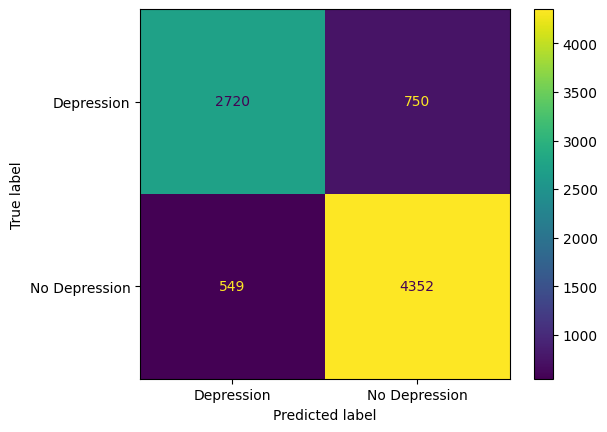

In [23]:
#checking how well it actually preforms on the test dataset
ConfusionMatrixDisplay.from_estimator(clf_xgb,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels=["Depression","No Depression"])

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

y_pred = clf_xgb.predict(X_test)
y_prob = clf_xgb.predict_proba(X_test)[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_prob))

Accuracy: 0.8448214072392785
Precision: 0.8529988239905919
Recall: 0.8879820444807183
F1: 0.8701389583125062
AUC: 0.9190097357064693
